In [2]:
import os
from vllm import LLM, SamplingParams
import transformers
import datasets
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from generate_text import _truncate_prompt, _phi3_ify, _get_llama_param_name, _get_mistral_param_name
from utils import get_sequence_level_logits

In [2]:
plt.rcParams.update({
    # Fonts (increased further for visibility)
    'font.size': 28,                      # Default font size
    'font.family': 'serif',               # Set font family to 'serif'
    'font.serif': ['Times New Roman', 'DejaVu Math TeX Gyre', 'DejaVu Serif'],  # Serif fonts
    'axes.titlesize': 30,                 # Title font size (even larger)
    'axes.labelsize': 30,                 # Axis label font size
    'legend.fontsize': 26,                # Legend font size
    'xtick.labelsize': 24,                # X-tick label font size
    'ytick.labelsize': 24,                # Y-tick label font size
    
    # Figure size and DPI
    'figure.figsize': [10, 8],            # Same figure size, but adjust as needed
    'figure.dpi': 100,                    # Higher resolution for clarity
    
    # Line properties
    'lines.linewidth': 4,                 # Default line thickness
    'lines.markersize': 15,               # Marker size
    
    # Axes
    'axes.grid': True,                    # Grid on
    'grid.color': 'gray',                 # Grid color
    'grid.linestyle': '-',                # Solid grid line style
    'grid.linewidth': 0.75,               # Grid line width
    'axes.edgecolor': 'black',            # Axes border color
    'axes.linewidth': 1.5,                # Thicker axes border
    'axes.titleweight': 'bold',           # Bold titles
    
    # Set default x-axis to start at 0
    'axes.autolimit_mode': 'round_numbers',  # Round axis limits
    'axes.xmargin': 0.0,                    # Remove extra margin on x-axis
    'axes.ymargin': 0.05,                 # Slight y-axis margin
    
    # Ticks
    'xtick.major.size': 7,                # Major tick size
    'xtick.major.width': 1.5,             # Major tick width
    'ytick.major.size': 7,                # Major tick size
    'ytick.major.width': 1.5,             # Major tick width
    
    # Legend
    'legend.frameon': True,               # Frame around legend
    'legend.framealpha': 0.9,             # Slightly transparent frame
    'legend.fancybox': True,              # Rounded corners
    
    # Save figure
    'savefig.dpi': 300,                   # High resolution for saving
    'savefig.format': 'png',              # Save format
    'savefig.bbox': 'tight',              # Tight layout for saving
})
default_cycler = plt.rcParams['axes.prop_cycle']
default_cycler = [c['color'] for c in default_cycler]

In [3]:
def _parse_response(request_output):
    """
    Given a vllm request output, returns a parsed dictionary containing the necessary fields
    """
    output = {}

    output['prompt'] = request_output.prompt
    output['prompt_token_ids'] = request_output.prompt_token_ids
    responses = request_output.outputs # take most likely response

    texts = [response.text for response in responses]
    logprobs = [response.cumulative_logprob for response in responses]
    response_token_ids = [response.token_ids for response in responses]
    output['response'] = texts
    output['response_token_ids'] = response_token_ids
    output['logprobs'] = logprobs


    return output

def _get_gradient_norm(model, prompt, response, params, device='cuda'):
    prompt_tensor = torch.tensor(prompt).unsqueeze(0).to(device).long()
    output_tensor = torch.tensor(response).unsqueeze(0).to(device).long()
    prompt_len = prompt_tensor.shape[1]

    inputs = torch.cat([prompt_tensor, output_tensor], dim=1)
    model.zero_grad()
    cumulative_logits = get_sequence_level_logits(model, inputs, prompt_length=prompt_len)
    cumulative_logits.backward()
    return {name: param.grad.norm().item() for name, param in model.named_parameters() if name in params}

def get_gradients(model, outputs, params, device='cuda'):
    """
    Given a model and a list of outputs, returns the gradients of the model's parameters with respect to the outputs
    """
    for output in outputs:
        prompt_token_ids = output['prompt_token_ids']
        grad_norms = []
        for response_token_ids in output['response_token_ids']:
            grad_norms.append(_get_gradient_norm(model, prompt_token_ids, response_token_ids, params, device=device))
        
        output['grad_norms'] = grad_norms
    return outputs

In [4]:
model_name = 'microsoft/Phi-3-mini-4k-instruct' # 'meta-llama/Meta-Llama-3.1-8B' 'mistralai/Mistral-7B-v0.3' 
params = {
    '20@@@down_proj@@@weight',
}

seed = 133337


## Sampling parameters
gpu_memory_utilization = 0.9
temperature = 1.0
num_responses = 150
max_tokens = 1000

## Data Parameters
max_samples = 5
data_name = 'allenai/c4'
subdata_name = 'realnewslike'
split = 'train'
prompt_field_name = 'text'
max_prompt_length = 100


## Miscellaneous
master_parent = '/home/blockadam/gaussian-watermarking'
device = 'cuda'

if 'Phi' in model_name:
    alias = 'phi'
    _get_param_name = _get_llama_param_name
elif 'Llama' in model_name:
    alias = 'llama'
    _get_param_name = _get_llama_param_name
elif 'Mistral' in model_name:
    alias = 'mistral'
    _get_param_name = _get_mistral_param_name
else:
    raise ValueError(f"Unknown model name {model_name}")

param_names = []
for param in params:
    layer_idx, proj_type, param_type = param.split('@@@')
    param_name = _get_param_name(layer_idx, proj_type, param_type)
    param_names.append(param_name)
params = set(param_names)

In [4]:
data = datasets.load_dataset(data_name, subdata_name, split=split, streaming=True)
prompts = []
counter = 0
for datum in iter(data):
    prompt = datum[prompt_field_name]
    prompts.append(prompt)
    counter += 1
    if counter == max_samples:
        break

truncate = lambda prompt:_truncate_prompt(prompt, max_prompt_length)
prompts = [truncate(prompt) for prompt in prompts]
if 'Phi-3' in model_name:
    prompts = [_phi3_ify(prompt) for prompt in prompts]

In [5]:
sampling_params = SamplingParams(
        n = num_responses,
        seed = seed,
        max_tokens=max_tokens,
        temperature=temperature,
        logprobs=0, # Return logprobs
        top_k=-1,
    )
llm = LLM(model_name, gpu_memory_utilization=gpu_memory_utilization)

responses = llm.generate(prompts, sampling_params)
responses = [_parse_response(response) for response in responses]

INFO 12-20 22:09:29 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post1) with config: model='microsoft/Phi-3-mini-4k-instruct', speculative_config=None, tokenizer='microsoft/Phi-3-mini-4k-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=microsoft/Phi-3-mini-4k-instruct, use_v2_block_manager=False, num_scheduler_steps=1, enable_prefix_cac

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


INFO 12-20 22:09:36 model_runner.py:997] Starting to load model microsoft/Phi-3-mini-4k-instruct...
INFO 12-20 22:09:36 selector.py:240] Cannot use FlashAttention-2 backend due to sliding window.
INFO 12-20 22:09:36 selector.py:116] Using XFormers backend.
INFO 12-20 22:09:36 weight_utils.py:242] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  3.40it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.03it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.15it/s]



INFO 12-20 22:09:38 model_runner.py:1008] Loading model weights took 7.1183 GB
INFO 12-20 22:09:38 gpu_executor.py:122] # GPU blocks: 10856, # CPU blocks: 682
INFO 12-20 22:09:41 model_runner.py:1309] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-20 22:09:41 model_runner.py:1313] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 12-20 22:09:54 model_runner.py:1428] Graph capturing finished in 14 secs.


Processed prompts: 100%|██████████| 5/5 [01:29<00:00, 17.88s/it, est. speed input: 2.70 toks/s, output: 4277.14 toks/s]


In [6]:
path = os.path.join(master_parent,'data', 'gradient_norms', f'{alias}_responses.json')
os.makedirs(os.path.dirname(path), exist_ok=True)
print(f"Saving responses to {path}")
with open(path, 'w') as f:
    json.dump(responses, f)

Saving responses to /home/blockadam/gaussian-watermarking/data/gradient_norms/phi_responses.json


In [7]:
del llm

In [8]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)
for name, param in model.named_parameters():
    if name in params:
        param.requires_grad = True
    else:
        param.requires_grad = False



Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


In [9]:
responses = get_gradients(model, responses, params, device=device)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
You are not running the flash-attention implementation, expect numerical differences.


In [10]:
print(f"Saving responses to {path}")
with open(path, 'w') as f:
    json.dump(responses, f)

Saving responses to /home/blockadam/gaussian-watermarking/data/gradient_norms/phi_responses.json


In [5]:
path = os.path.join(master_parent,'data', 'gradient_norms', f'{alias}_responses.json')
with open(path, 'r') as f:
    responses = json.load(f)

In [6]:
param = 'model.layers.20.mlp.down_proj.weight'
grads = []
for response in responses:
    temp = []
    for grad_norms in response['grad_norms']:
        temp.append(grad_norms[param])
    grads.append(temp)


grads = np.array(grads)

Prompt 0 Norm Range: 17.62
Prompt 1 Norm Range: 4.06
Prompt 2 Norm Range: 23.93
Prompt 3 Norm Range: 26.10
Prompt 4 Norm Range: 36.13


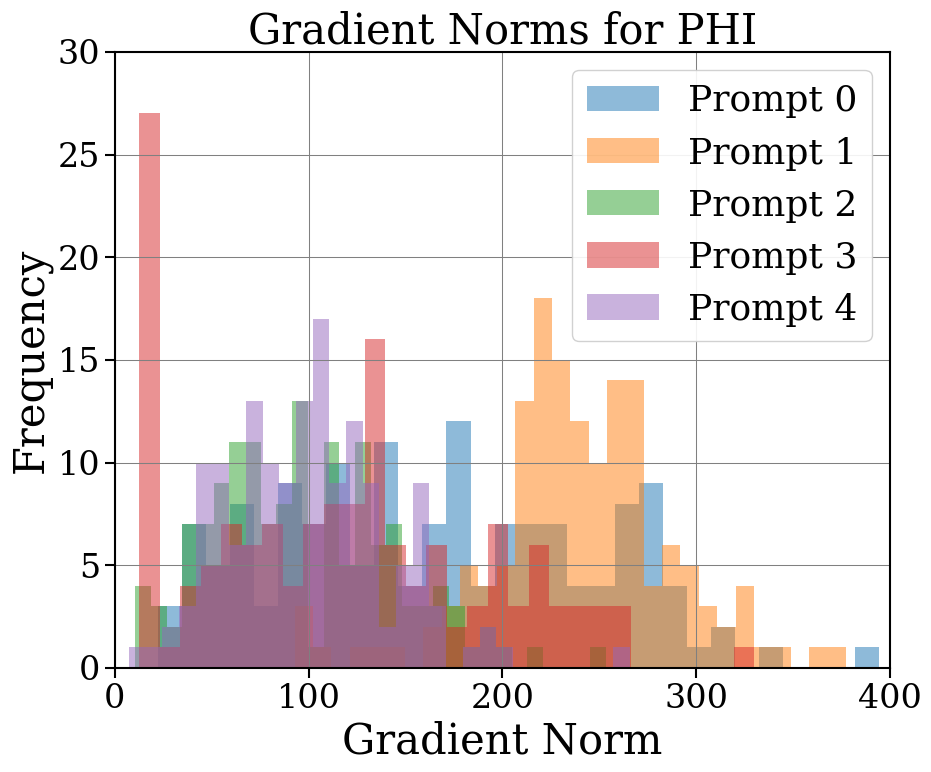

In [9]:
fig, ax = plt.subplots()
bins = 30
alpha = 0.5
for i, response in enumerate(responses):
    grad_norms = grads[i,:]
    grad_norms = grad_norms[grad_norms != 0]
    # mean = np.median(grad_norms)
    # grad_norms = grad_norms / mean
    norm_range = np.max(grad_norms) / np.min(grad_norms)
    ax.hist(grad_norms, bins=bins, alpha=alpha, label=f"Prompt {i}")
    print(f"Prompt {i} Norm Range: {norm_range:.2f}")

ax.set_xlabel('Gradient Norm')
ax.set_ylabel('Frequency')
ax.set_title(f'Gradient Norms for {alias.upper()}')
ax.legend()
plt.show()

In [21]:
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

In [6]:
8192 * 3072

25165824

In [2]:
import transformers

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# model = transformers.AutoModelForCausalLM.from_pretrained('mistralai/Mistral-7B-v0.3')   
model = transformers.AutoModelForCausalLM.from_pretrained('meta-llama/Meta-Llama-3.1-8B')

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


In [8]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb

In [5]:
14336 * 4096

58720256

# Getting Mistral Perplexities

In [1]:
import torch
from vllm import LLM, SamplingParams
import datasets
import numpy as np

import os
import json

import time

import hydra
from omegaconf import OmegaConf

from utils import save_amulet_metadata, get_watermark_path, hf_login, save_config, override_watermark_params
from hf_core import VanillaLMWatermarker, LowRankLMWatermarker, LaserizedLowRankLMWatermarker

from generate_text import get_model_type, get_watermark_param_names, get_data

def get_cumulative_logprobs(response):
    prompt_token_ids = response.prompt_token_ids
    cum_logprobs = 0.0
    for i, prompt_logprob in enumerate(response.prompt_logprobs):
        if i == 0:
            continue
        log_prob = prompt_logprob[prompt_token_ids[i]].logprob
        cum_logprobs += log_prob
    return cum_logprobs



def get_perplexities(llm, prompts):
    """
    Given a vllm llm, returns the cumulative log probabilities under the reference model of the answers
    """

    log_probs_config = SamplingParams(
        n=1,
        max_tokens=1,
        prompt_logprobs=0,
    )

    responses = llm.generate(prompts, log_probs_config)
    outputs = []
    for response in responses:
        if response is None:
            continue
        if response.prompt_logprobs is None:
            continue
        prompt = response.prompt
        prompt_len = len(response.prompt_token_ids)
        prompt_cumlogprob = get_cumulative_logprobs(response)
        per_token_logprob = prompt_cumlogprob / prompt_len
        perplexity = float(np.exp(-per_token_logprob))
        outputs.append({
            'prompt': prompt,
            'perplexity': perplexity,
            'length': prompt_len,
            'logprob': prompt_cumlogprob
        })
    
    return outputs


def get_perplexity_statistics(outputs):

    logprobs, lengths, perplexities = [], [], []
    for output in outputs:
        logprobs.append(output['logprob'])
        lengths.append(output['length'])
        perplexities.append(output['perplexity'])
    
    return {
        'avg_logprob': np.mean(logprobs),
        'std_logprob': np.std(logprobs),
        'avg_length': np.mean(lengths),
        'std_length': np.std(lengths),
        'avg_perplexity': np.mean(perplexities),
        'std_perplexity': np.std(perplexities)
    }

def get_data(name, subdata_name, split, max_samples, prompt_field_name='text', truncation=None):

    data = datasets.load_dataset(name, subdata_name, split=split, streaming=True)
    prompts = []
    counter = 0
    for datum in iter(data):
        prompt = datum[prompt_field_name]
        if truncation is not None:
            prompt = prompt[:truncation]
        prompts.append(prompt)
        counter += 1
        if counter == max_samples:
            break

    return prompts

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-23 23:02:41,537	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
prompts = get_data('allenai/c4', 'realnewslike', 'train', 1000, truncation=500)

In [4]:
# model = 'mistralai/Mistral-7B-v0.3'
model = '/home/blockadam/gaussian-watermarking/models/mistralai-Mistral-7B-v0.3_seed_1997_rank_0'
gpu_memory_utilization = 0.9

llm = LLM(model, gpu_memory_utilization=gpu_memory_utilization,max_num_seqs=1, tokenizer='mistralai/Mistral-7B-v0.3')

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/home/blockadam/gaussian-watermarking/models/mistralai-Mistral-7B-v0.3_seed_1997_rank_0'. Use `repo_type` argument if needed.

In [4]:
perplexities = get_perplexities(llm, prompts)

Processed prompts: 100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s, est. speed input: 3618.75 toks/s, output: 29.93 toks/s]


In [6]:
parent = os.path.join('/home/blockadam/gaussian-watermarking', 'amlt', '12-10-perplexities')
# exp_name = 'grid_12-10-perplexities_see_1997_wat_mistralai-Mistral-7B-v0.3_____0_____20___down_proj___weight_____0.0'
# exp_name = 'grid_12-10-perplexities_see_1997_wat_mistralai-Mistral-7B-v0.3_____0_____20___up_proj___weight_____1e-05'
exp_name = 'grid_12-10-perplexities_see_1997_wat_mistralai-Mistral-7B-v0.3_____1024_____30___up_proj___weight_____1e-05'
path = os.path.join(parent, exp_name, 'perplexities.json')
os.makedirs(os.path.dirname(path), exist_ok=True)
# with open(path, 'w') as f:
#     json.dump(perplexities, f)